In [11]:
import photontorch as pt
import torch
import numpy as np
from ring import RingNet, Ring
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/envs/photontorch/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


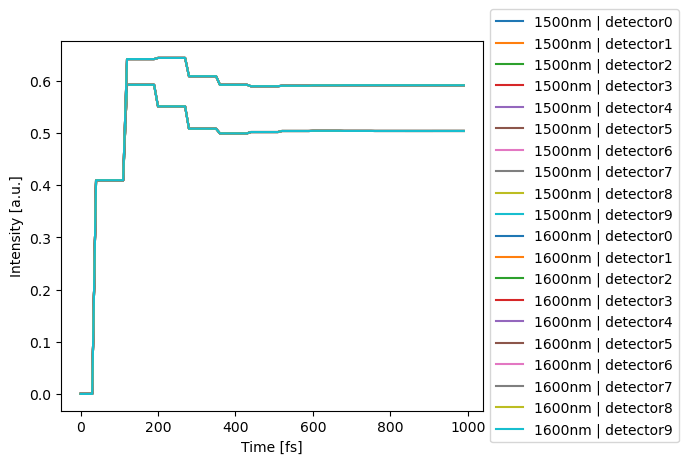

In [12]:
# 测试仿真时间，确保采集稳定光强
wavelength_list = 1e-6*np.linspace(1.5, 1.6, 2)
env = pt.Environment(t0=0, t1=1e-12, t2=1e-13, wl=wavelength_list, grad=True)
with env:
    ring = RingNet(10, 2, mode=0)
    detected = ring(source = 1)
    ring.plot(detected)

In [ ]:
# 查看微环的可训练参数
for i in ring.named_parameters():
    print(i)

In [19]:
class MZI(pt.Network):
    def __init__(self, phi, theta):
        super(MZI, self).__init__()
        self.add_component("mzi", pt.Mzi(phi=phi, theta=theta))
        self.add_component("src", pt.Source())
        self.add_component('det', pt.Detector())
        self.add_component("term", pt.Term())
        self.link("src:0", "0:mzi:1", "0:det")
        self.link("term:0", "2:mzi:3", "0:term")

wavelength_list = 1e-6*np.linspace(1.5, 1.6, 1000)
env = pt.Environment(t_start = 0, t_end = 1e-11, dt = 1e-12, wl = 1.55e-6, grad=False)
pt.set_environment(env)
cha_phi_det = []
cha_theta_det = []
phase_list = np.linspace(0, 2*np.pi, 1000)

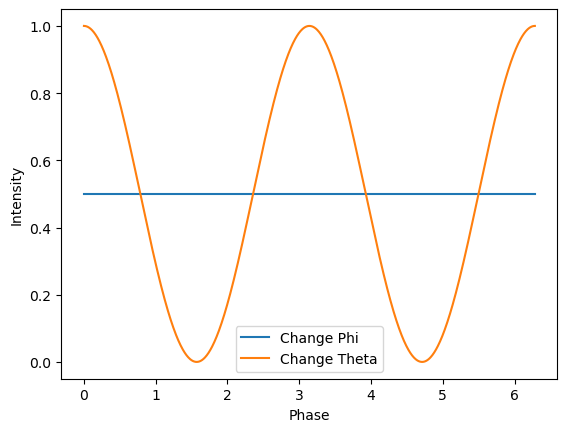

In [20]:
for i in phase_list:
    mzi = MZI(phi=0, theta=i)
    detected = mzi(source = 1)[-1, 0, 0, 0]
    cha_theta_det.append(detected.numpy())

for i in phase_list:
    mzi = MZI(phi=i, theta=np.pi / 4)
    detected = mzi(source = 1)[-1, 0, 0, 0]
    cha_phi_det.append(detected.numpy())

plt.plot(phase_list, cha_phi_det, label = "Change Phi")
plt.plot(phase_list, cha_theta_det, label = "Change Theta")
plt.legend()
plt.ylabel("Intensity")
plt.xlabel("Phase")
plt.show()

In [11]:
class DirCoupler(pt.Network):
    def __init__(self, coe):
        super(DirCoupler, self).__init__()
        self.add_component("dc", pt.DirectionalCoupler(coupling=coe))
        self.add_component("src", pt.Source())
        self.add_component('det1', pt.Detector())
        self.add_component("det2", pt.Detector())
        self.term = pt.Term()
        self.link("src:0", "0:dc:1", "0:det1")
        self.link("det2:0", "2:dc:3", "0:term")

In [23]:
wavelength_list = 1e-6*np.linspace(1.5, 1.6, 1000)
dc = DirCoupler(coe = 0.7)
env = pt.Environment(t_start = 0, t_end = 1e-11, dt = 1e-12, wl = wavelength_list, grad=False)
with env:
    detected = dc(source = 1)[-1, :, :, 0]
    # det1 = detected[0]
    # det2 = detected[1]

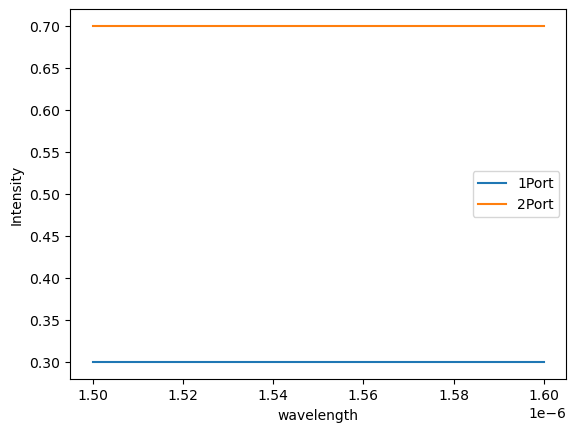

In [24]:
plt.plot(wavelength_list, detected[:, 0], label="1Port")
plt.plot(wavelength_list, detected[:, 1], label="2Port")
plt.xlabel("wavelength")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [15]:
class DirCouplerWiLen(pt.Network):
    def __init__(self, length, coupling, loss, neff, wl0, phase):
        super(DirCouplerWiLen, self).__init__()
        self.add_component("dc", pt.DirectionalCouplerWithLength(length=length, coupling=coupling, loss=loss, neff=neff, wl0=wl0, phase=phase))
        self.add_component("src", pt.Source())
        self.add_component('det1', pt.Detector())
        self.add_component("det2", pt.Detector())
        self.term = pt.Term()
        self.link("src:0", "0:dc:1", "0:det1")
        self.link("det2:0", "2:dc:3", "0:term")

In [25]:
dc = DirCouplerWiLen(length=1e-5, coupling=0.6, loss=0, neff=2.34, wl0=1.55e-6, phase=0)
env = pt.Environment(t_start = 0, t_end = 1e-11, dt = 1e-12, wl = wavelength_list, grad=False)
with env:
    detected = dc(source = 1)[-1, :, :, 0]
    # det1 = detected[0]
    # det2 = detected[1]

/opt/homebrew/anaconda3/envs/photontorch/lib/python3.9/site-packages/photontorch/networks/network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


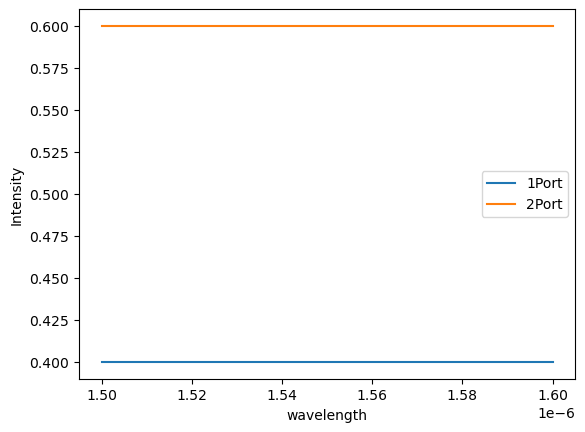

In [26]:
plt.plot(wavelength_list, detected[:, 0], label="1Port")
plt.plot(wavelength_list, detected[:, 1], label="2Port")
plt.xlabel("wavelength")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [21]:
class ReDirCoupler(pt.Network):
    def __init__(self, length, wl0):
        super(ReDirCoupler, self).__init__()
        self.add_component("dc", pt.RealisticDirectionalCoupler(length=length, wl0=wl0))
        self.add_component("src", pt.Source())
        self.add_component('det1', pt.Detector())
        self.add_component("det2", pt.Detector())
        self.term = pt.Term()
        self.link("src:0", "0:dc:1", "0:det1")
        self.link("det2:0", "2:dc:3", "0:term")

In [35]:
dc = ReDirCoupler(length=1e-5, wl0=1.55e-6)
wavelength_list = 1e-6 * np.linspace(1.5, 1.6, 10000)
env = pt.Environment(t_start = 0, t_end = 1e-8, dt = 1e-9, wl = wavelength_list, grad=False)
with env:
    detected = dc(source = 1)[-1, :, :, 0]

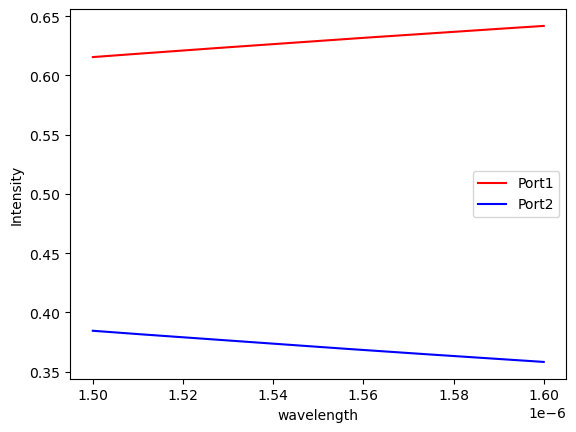

In [36]:
plt.plot(wavelength_list, detected[:, 0], '-r', label = "Port1")
plt.plot(wavelength_list, detected[:, 1], '-b', label = "Port2")
plt.xlabel("wavelength")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [31]:
class WG(pt.Network):
    def __init__(self):
        super(WG, self).__init__()
        self.wg = pt.Waveguide(length=6.624e-7, loss=10, wl0=1.55e-6, phase=0)
        self.src = pt.Source()
        self.det = pt.Detector()
        self.link("src:0", "0:wg:1", "0:det")

In [34]:
wg1 = WG()
wavelength_list = 1e-6 * np.linspace(1.45, 1.55, 1000)
env = pt.Environment(t_start = 0, t_end = 1e-8, dt = 1e-9, wl = 1.55e-6, grad=False)
with env:
    detected = wg1(source = 1)[-1, :, 0, 0]
    print(detected)
    # plt.plot(wavelength_list, detected)
    # plt.xlabel("wavelength")
    # plt.ylabel("Intensity")
    # plt.legend()
    # plt.show()

tensor([1.0000])


In [3]:
class SingleRingStructure(pt.Network):
    def __init__(self, phase, neff):
        super(SingleRingStructure, self).__init__()
        # ring_length = 6.624e-6
        ring_length = 1.58e-6 /2.34 * 10
        self.add_component("dc1", pt.DirectionalCoupler(coupling=0.4, trainable=False))
        self.add_component("dc2", pt.DirectionalCoupler(coupling=0.4, trainable=False))
        self.add_component("wg1", pt.Waveguide(length = ring_length/2, loss=10, phase = 0, trainable = False, neff=neff))
        self.add_component("wg2", pt.Waveguide(length = ring_length/2, loss=10, phase = phase/2, trainable = True, neff=neff))
        # Term 连接MZI多余端口
        self.add_component("term1", pt.Term())
        self.add_component("term2", pt.Term())        
        self.link(0, "0:dc1:3", "0:wg1:1", "0:dc2:1", "1:wg2:0", "2:dc1:1", 1)
        self.link(3, "3:dc2:2", 2)

class RingConnected(pt.Network):
    def __init__(self, phase, neff):
        # wavelength 表示构建微环的谐振波长
        super(RingConnected, self).__init__()
        self.add_component("source", pt.Source())
        self.add_component("detector1", pt.Detector())
        self.add_component("detector2", pt.Detector())
        self.add_component("term", pt.Term())
        self.ring = SingleRingStructure(phase=phase, neff=neff)

        self.link("source:0", "0:ring:1", "0:detector1")
        self.link("detector2:0", "3:ring:2", "0:term")

In [4]:
wavelength_list = 1e-6*np.linspace(1.3, 1.8, 10000)
env = pt.Environment(t_start = 0, t_end = 1e-11, dt = 1e-12, wl = wavelength_list, grad=False, freqdomain=True)
pt.set_environment(env)

In [5]:
detected_through = []
detected_drop = []

/opt/homebrew/anaconda3/envs/photontorch/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


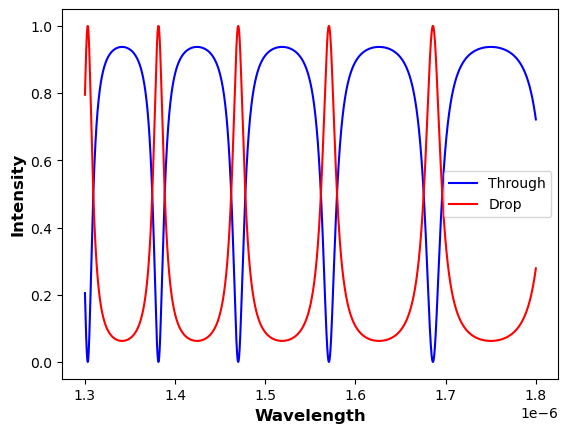

In [6]:
ring = RingConnected(phase=0, neff=2.34)
detected = ring(source = 1)[-1, :, :, 0]
detected_through = detected[:, 0]
detected_drop = detected[:, 1]
plt.plot(wavelength_list, np.array(detected_through), 'b-', label = "Through")
plt.plot(wavelength_list, np.array(detected_drop), 'r-', label = "Drop")
plt.xlabel("Wavelength", weight="bold", fontsize=12)
plt.ylabel("Intensity", weight="bold", fontsize=12)
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/photontorch/lib/python3.9/site-packages/photontorch/networks/network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(
/opt/homebrew/anaconda3/envs/photontorch/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


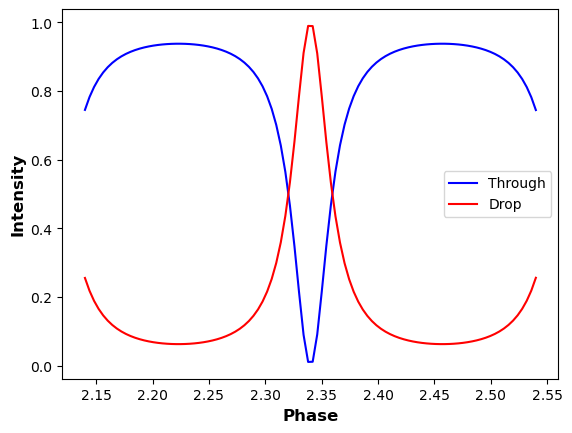

In [3]:
env = pt.Environment(t_start = 0, t_end = 1e-11, dt = 1e-12, wl = 1.55e-6, grad=False)
neff_list = np.linspace(2.14, 2.54, 100)
detected_through = []
detected_drop = []
with env:
    for i in neff_list:
        ring = RingConnected(phase=0, neff = i)
        detected = ring(source = 1)[-1, 0, :, 0]
        detected_through.append(detected[0])
        detected_drop.append(detected[1])
    plt.plot(neff_list, np.array(detected_through), 'b-', label = "Through")
    plt.plot(neff_list, np.array(detected_drop), 'r-', label = "Drop")
    plt.xlabel("Phase", weight="bold", fontsize=12)
    plt.ylabel("Intensity", weight="bold", fontsize=12)
    plt.legend()
    plt.show()

In [7]:
env = pt.Environment(t_start = 0, t_end = 1e-11, dt = 1e-12, wl = 1.55e-6, grad=False)
phase_list = np.linspace(0, 12 * np.pi, 100)
detected_through = []
detected_drop = []
with env:
    for i in phase_list:
        ring = RingConnected(phase=i, neff = 2.34)
        detected = ring(source = 1)[-1, 0, :, 0]
        detected_through.append(detected[0])
        detected_drop.append(detected[1])
    plt.plot(phase_list, np.array(detected_through), 'b-', label = "Through")
    plt.plot(phase_list, np.array(detected_drop), 'r-', label = "Drop")
    plt.xlabel("Phase", weight="bold", fontsize=12)
    plt.ylabel("Intensity", weight="bold", fontsize=12)
    plt.legend()
    plt.show()

TypeError: __init__() got an unexpected keyword argument 'phase'